In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip

%matplotlib inline

In [2]:
# 1. Calibrate Camera, by giving it chessboard image and obtaining the correction coefficients (Once)
# 2. Undistort image
# 3. Crop image, and do gradient and so on, to obtain a clear binary representation of the lane lines
# 4. Perspective Transform and warp

###################### CALIBRATE ######################


# Calibration and coefficients extraction


objpts = []
imgpts = []

nx = 9
ny = 6

objp = np.zeros((nx * ny, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

image_paths = glob.glob('camera_cal/calibration*.jpg')

for path in image_paths:
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret == True:
        
        imgpts.append(corners)
        objpts.append(objp)
        
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)



ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, gray.shape[::-1], None, None)


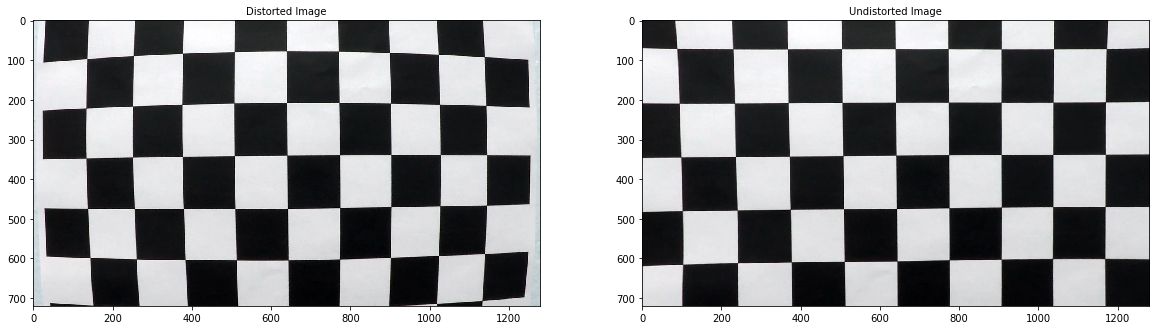

In [3]:
dist_test_img = cv2.imread('camera_cal/calibration1.jpg')
undist_test_img = cv2.undistort(dist_test_img, mtx, dist, None, mtx)

f, (ax1) = plt.subplots(1, 2, figsize = (20, 20))
ax1[0].imshow(dist_test_img)
ax1[0].set_title('Distorted Image', fontsize = 10)
ax1[1].imshow(undist_test_img)
ax1[1].set_title('Undistorted Image', fontsize = 10)

In [4]:
# Function for undistorting and warping perspective, and returng the inv Matrix for use later


def undistort(img, ret, mtx, dist):
    
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undistorted

def warp(undistorted):
    
    img_size = (undistorted.shape[1], undistorted.shape[0])
    
    src_pts = np.float32([[220,720], [1110, 720], [722, 470], [570, 470]])
    dst_pts = np.float32([[320,720], [920, 720], [920, 1], [320, 1]])
    
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    Minv = cv2.getPerspectiveTransform(dst_pts, src_pts)
    warped = cv2.warpPerspective(undistorted, M, img_size, flags = cv2.INTER_LINEAR)
    
    return warped, Minv

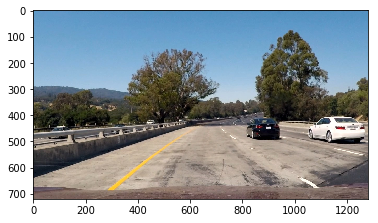

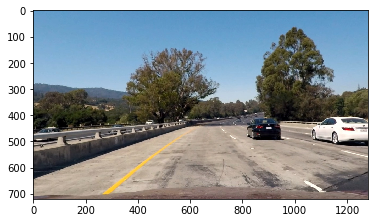

In [5]:
distorted = cv2.imread('test_images/test1.jpg')
distorted = cv2.cvtColor(distorted, cv2.COLOR_BGR2RGB)
undistorted_img = undistort(distorted, ret, mtx, dist)
plt.imshow(distorted)
plt.figure()
plt.imshow(undistorted_img)


In [6]:
###################### SOBEL GRADIENT X AND Y, SOBEL GRADIENT MAGNITUDE, SOBEL DIRECTION, AND ALL COMBINED ######################


def grad(img, mode, k, thresh):
    
    gray = img
    
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = k)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = k)
    sobel_x_abs = np.absolute(sobel_x)
    sobel_y_abs = np.absolute(sobel_y)
    
    if mode == 'x_grad':
        # Sobel operator x
        sobel_x_abs_scaled = ((sobel_x_abs / np.max(sobel_x_abs)) * 255).astype(np.uint8)
        indices_x = (sobel_x_abs_scaled >= thresh[0]) & (sobel_x_abs_scaled <= thresh[1])
        binary_output_x = np.zeros_like(img)
        binary_output_x[indices_x] = 1
        return binary_output_x
    elif mode == 'y_grad':
        # Sobel operator y
        sobel_y_abs_scaled = ((sobel_y_abs / np.max(sobel_y_abs)) * 255).astype(np.uint8)
        indices_y = (sobel_y_abs_scaled >= thresh[0]) & (sobel_y_abs_scaled <= thresh[1])   
        binary_output_y = np.zeros_like(img)
        binary_output_y[indices_y] = 1
        return binary_output_y
    elif mode == 'mag':
        # Gradient magnitude
        gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
        gradmag_scaled = ((gradmag/np.max(gradmag)) * 255).astype(np.uint8)
        indices_mag = (gradmag_scaled >= thresh[0]) & (gradmag_scaled <= thresh[1])
        #### zeros_like ###################
        binary_output_mag = np.zeros_like(img)
        binary_output_mag[indices_mag] = 1
        return binary_output_mag
    elif mode == 'dir':
        # Gradient direction
        grad_dir = np.absolute(np.arctan2(sobel_y_abs, sobel_x_abs))
        indices_dir = (grad_dir >= thresh[0]) & (grad_dir <= thresh[1])
        #### zeros_like ###################
        binary_output_dir = np.zeros_like(img)
        binary_output_dir[indices_dir] = 1
        return binary_output_dir
        
        
# Function for extracting single channels of color spaces, and thresholding

def hls_rgb(img, im_type, k, channel, mode, thresh):
    
    assert img.shape[2] == 3
    
    if im_type == 'hls':
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        # hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        if channel == 'h':
            data = hls[:, :, 0]
        if channel == 'l':
            data = hls[:, :, 1]
        if channel == 's':
            data = hls[:, :, 2]
    elif im_type == 'bgr':
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # rgb = img
        if channel == 'r':
            data = rgb[:, :, 0]
        if channel == 'g':
            data = rgb[:, :, 1]
        if channel == 'b':
            data = rgb[:, :, 2]
            
    output = np.zeros_like(data)
    
    if mode == 'single_binary':
        data = ((data / np.max(data)) * 255).astype(np.uint8)
        mask = (data > thresh[0]) & (data <= thresh[1])
        output[mask] = 1
    
    elif mode == 'isolate':
        
        output = data
        """
    elif mode == 'single_x_grad':
        sobel_x = cv2.Sobel(data, cv2.CV_64F, 1, 0, ksize = k)
        sobel_x_abs = np.absolute(sobel_x)
        sobel_x_abs_scaled = ((sobel_x_abs / np.max(sobel_x_abs)) * 255).astype(np.uint8)
        mask = (sobel_x_abs_scaled >= thresh[0]) & (sobel_x_abs_scaled <= thresh[1])
        output[mask] = 1
        """
    
    return output


# Functions for combining thresholds

def combine_AND(img1, img2):
    combined = np.zeros_like(img1)
    combined_indices = (img1 == 1) & (img2 == 1)
    combined[combined_indices] = 1

    return combined

def combine_OR(img1, img2):
    combined = np.zeros_like(img1)
    combined_indices = (img1 == 1) | (img2 == 1)
    combined[combined_indices] = 1

    return combined



# Final thresholding function
# Green and red channels are thresholded to detect yellow lines
# L performs well under different lighting conditions
# S and x gradients perform well in general
# The combination of all of those lead to an ok thresolded image where the lanes are for the most part identfiable

def get_thresholded(img):
    
    img = undistort(img, ret, mtx, dist)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sx_binary = grad(gray, mode = 'x_grad', k = 3, thresh = (20, 200))
    dir_binary = grad(gray, mode = 'dir', k = 3, thresh=(np.pi/6, np.pi/2))
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))

    
    # R & G thresholds so that yellow lanes are detected well.
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # rgb = img
    color_threshold = 100
    R = rgb[:,:,0]
    G = rgb[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)

    S = hls_rgb(img, 'hls', k = 3, channel = 's', mode = 'isolate', thresh = (100, 255))
    L = hls_rgb(img, 'hls', k = 3, channel = 'l', mode = 'isolate', thresh = (120, 255))

    s_thresh = (100, 255)
    l_thresh = (120, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])
    
    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
    
    thresholded = color_combined
    
    return thresholded

In [7]:
# Masking function for removing outliers and useless information
# A trapezoidal mask is implemented to help focus only on the lanes 

def mask_updated(img_in):
    # Pull out the x and y sizes and make a copy of the image
    ysize = img_in.shape[0]
    xsize = img_in.shape[1]
    # region_select = np.copy(img_in)
    region_select = np.zeros_like(img_in)

    # Define a triangle region of interest 
    # Keep in mind the origin (x=0, y=0) is in the upper left in image processing
    # Note: if you run this code, you'll find these are not sensible values!!
    # But you'll get a chance to play with them soon in a quiz 
    left_bottom = [200, ysize]
    right_bottom = [1200, ysize]
    right_top = [800, 450]
    left_top = [500, 450]
    apex = [np.int(xsize/2), np.int(ysize/2)]

    # Fit lines (y=Ax+B) to identify the  3 sided region of interest
    # np.polyfit() returns the coefficients [A, B] of the fit
    fit_left = np.polyfit((left_bottom[0], left_top[0]), (left_bottom[1], left_top[1]), 1)
    fit_right = np.polyfit((right_bottom[0], right_top[0]), (right_bottom[1], right_top[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)
    fit_top = np.polyfit((left_top[0], right_top[0]), (left_top[1], right_top[1]), 1)
    
    
    # Find the region inside the lines
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                        (YY > (XX*fit_right[0] + fit_right[1])) & \
                        (YY < (XX*fit_bottom[0] + fit_bottom[1])) & \
                        (YY > (XX*fit_top[0] + fit_top[1]))

    # Color pixels red which are inside the region of interest
    region_select[region_thresholds] = 1

    # Display the image
    return region_select * img_in

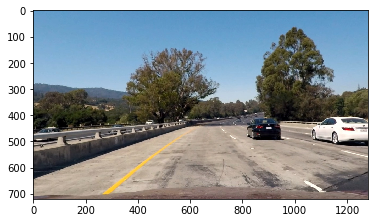

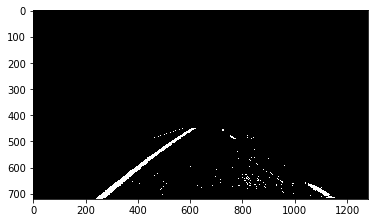

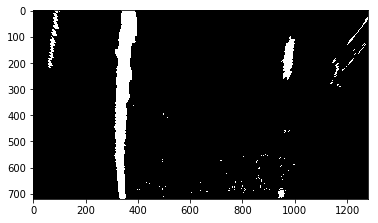

In [8]:
img55 = cv2.imread('test_images/test1.jpg')
img55 = undistort(img55, ret, mtx, dist)
thresholded= mask_updated(get_thresholded(img55))
thresholded_warped, _ = warp(thresholded)


plt.imshow(cv2.cvtColor(img55, cv2.COLOR_BGR2RGB))
plt.figure()
plt.imshow(thresholded, cmap = 'gray')
plt.figure()
plt.imshow(thresholded_warped, cmap = 'gray')

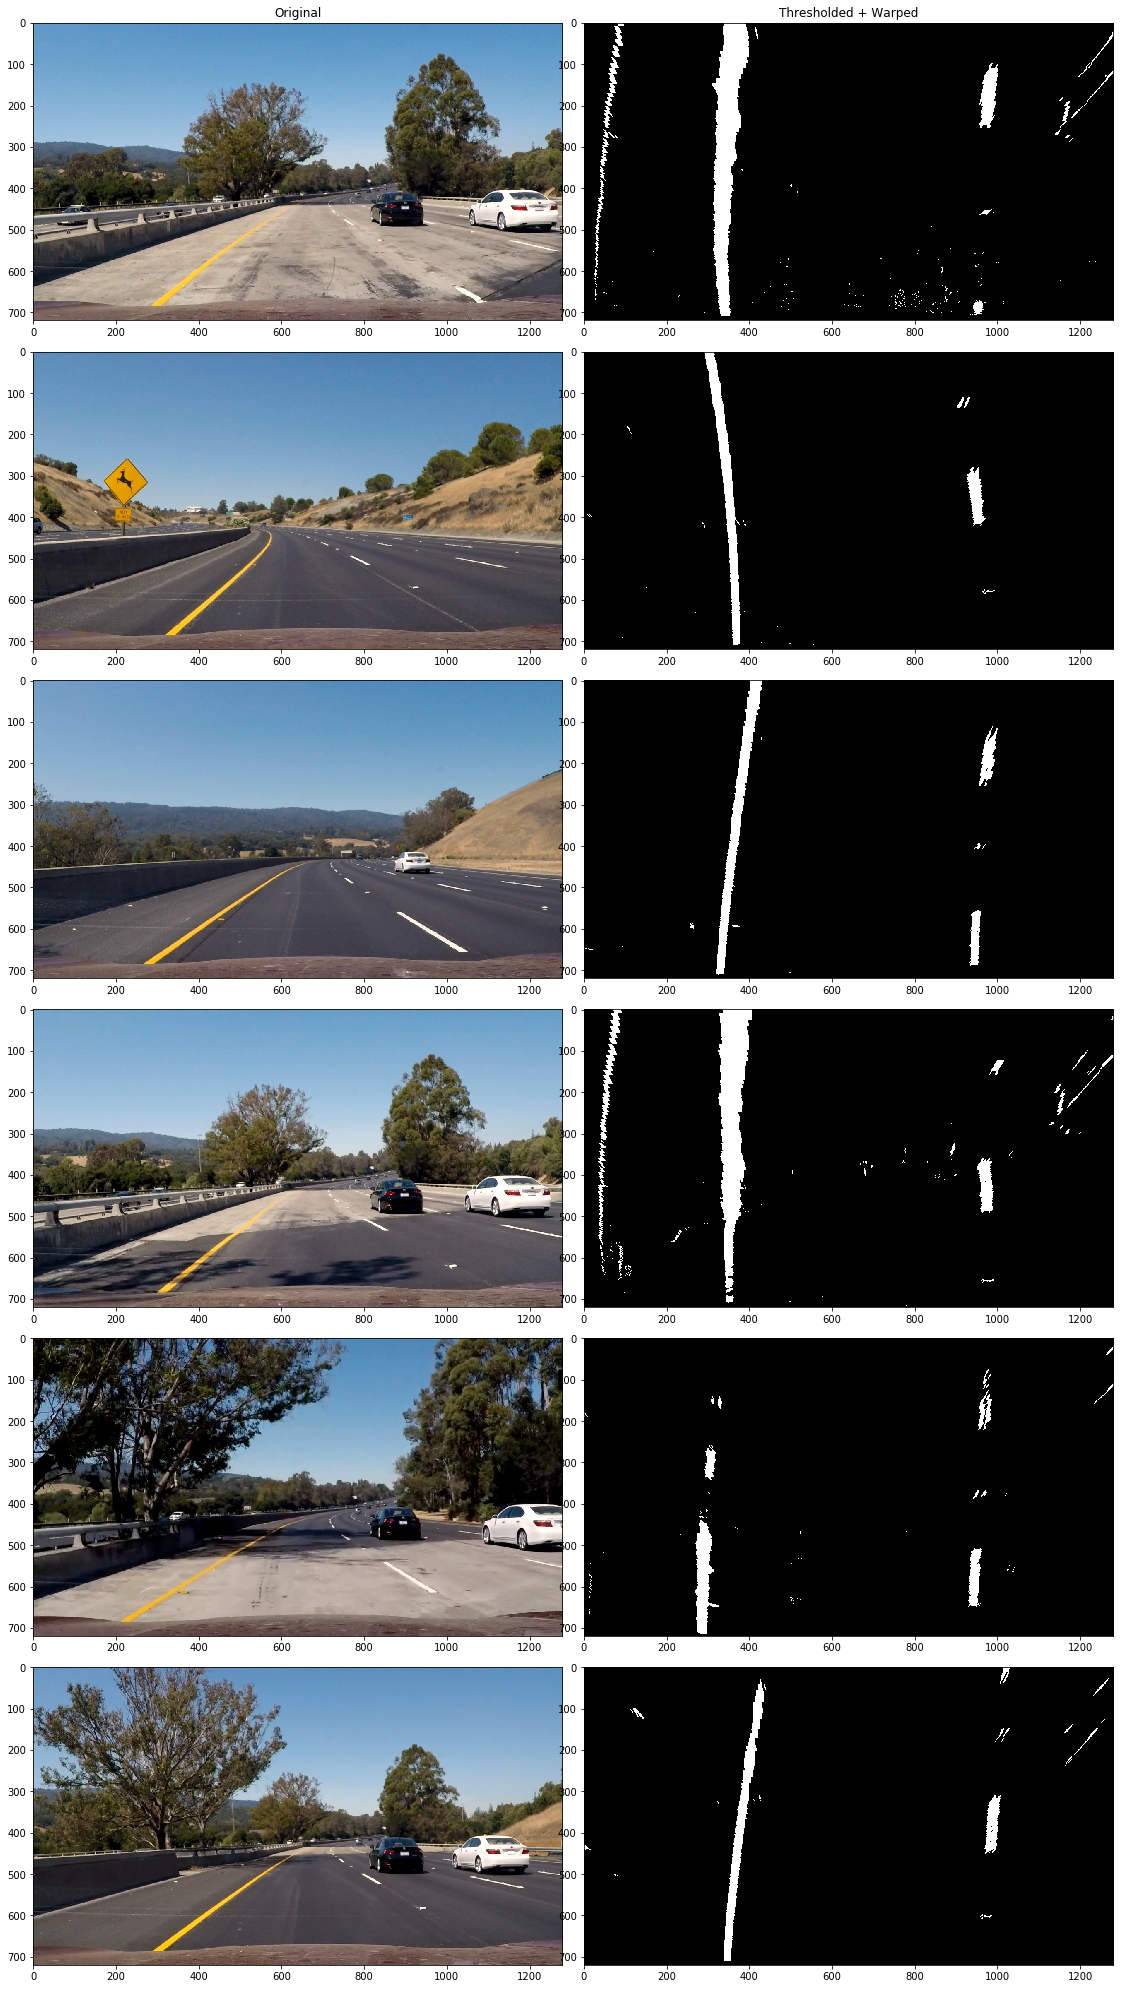

In [9]:
# Testing the previous functions simultaneously

test_imgs_paths = glob.glob('test_images/test*.jpg')

test_imgs = []
warped_imgs = []

for path in test_imgs_paths:
    img = cv2.imread(path)
    #######################
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_imgs.append(rgb_img)
    thresholded = get_thresholded(img)
    warped_img, _ = warp(thresholded)
    warped_imgs.append(warped_img)

f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 2, figsize = (30, 30))
f.tight_layout()

ax1[0].set_title('Original')
ax1[1].set_title('Thresholded + Warped')
# ax1[2].set_title('Warped')


ax1[0].imshow(test_imgs[0])
ax1[1].imshow(warped_imgs[0], cmap = 'gray')
# ax1[2].imshow(warped_imgs[0])
ax2[0].imshow(test_imgs[1])
ax2[1].imshow(warped_imgs[1], cmap = 'gray')
# ax2[2].imshow(warped_imgs[1])
ax3[0].imshow(test_imgs[2])
ax3[1].imshow(warped_imgs[2], cmap = 'gray')
# ax3[2].imshow(warped_imgs[2])
ax4[0].imshow(test_imgs[3])
ax4[1].imshow(warped_imgs[3], cmap = 'gray')
# ax4[2].imshow(warped_imgs[3])
ax5[0].imshow(test_imgs[4])
ax5[1].imshow(warped_imgs[4], cmap = 'gray')
# ax5[2].imshow(warped_imgs[4])
ax6[0].imshow(test_imgs[5])
ax6[1].imshow(warped_imgs[5], cmap = 'gray')
# ax6[2].imshow(warped_imgs[5])
# ax7[0].imshow(test_imgs[6])
# ax7[1].imshow(warped_imgs[6])
# ax7[2].imshow(warped_imgs[6])
# ax8[0].imshow(test_imgs[7])
# ax8[1].imshow(warped_imgs[7])
# ax8[2].imshow(warped_imgs[7])
plt.subplots_adjust(left=0., right=.5, top=0.9, bottom=0.)

In [10]:
# Image thresholded and warping pipeline

def pipeline(img):
    ########### takes BGR Images
    
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    undistorted = undistort(img, ret, mtx, dist)
    thresholded = mask_updated(get_thresholded(undistorted))
    warped_thresholded, Minv = warp(thresholded)
    # _, warped, Minv = undistort_warp(thresholded, ret, mtx, dist)
    
    return warped_thresholded, Minv

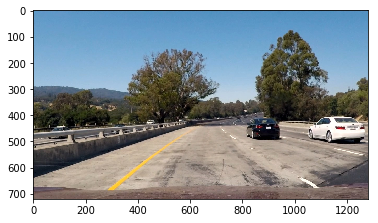

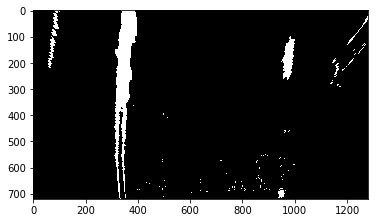

In [11]:
yyy = test_imgs[0]

# yyy = cv2.cvtColor(yyy, cv2.COLOR_RGB2BGR)
piped, Minv = pipeline(yyy)
plt.figure()
plt.imshow(yyy)
plt.figure()
plt.imshow(piped, cmap = 'gray')

In [12]:
#  Lane finding algorithm from the lectures implemented into a function


def sliding_window_polyfit(binary_warped):

    # Divide image by 2 row-wise, and sum all column elements
    hist = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis = 0)
    # hist is a 1D array of size (1280,)
    # print(hist.shape)
    # plt.plot(hist)
    # plt.figure()

    midpoint = np.int(hist.shape[0]/2)
    left_lane_most_likely_x_val = np.argmax(hist[:midpoint])
    right_lane_most_likely_x_val = np.argmax(hist[midpoint:]) + midpoint



    nwindows = 9
    window_height = np.int(binary_warped.shape[0] / nwindows)

    nonzero = binary_warped.nonzero()
    # print('nonzero tuple cotains indices of all non-zero pixels and its shape consists of two tuples (not arrays), one for each of the y and x indices')
    # print(np.array(nonzero).shape)

    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # print(np.unique(nonzerox))
    # print(np.unique(nonzeroy))

    left_rec_current_mid_x =  left_lane_most_likely_x_val
    right_rec_current_mid_x = right_lane_most_likely_x_val

    # print('margin is basically rectangle width divided by two')
    margin = 50
    min_pix = 50 

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []  

    rectangle_data = []



    for window in range(nwindows):
        y_top = binary_warped.shape[0] - (window + 1) * window_height
        y_bottom = binary_warped.shape[0] - window * window_height
        left_rec_x_left = left_rec_current_mid_x - margin
        left_rec_x_right = left_rec_current_mid_x + margin
        right_rec_x_left = right_rec_current_mid_x - margin
        right_rec_x_right = right_rec_current_mid_x + margin

        rectangle_data.append((y_top, y_bottom, left_rec_x_left, left_rec_x_right, right_rec_x_left, right_rec_x_right))
        ##########
        # cv2.rectangle(binary_warped, (rectangle_data[window][2], rectangle_data[window][0]), (rectangle_data[window][3], rectangle_data[window][1]), (0, 255, 0), 3)
        # cv2.rectangle(binary_warped, (rectangle_data[window][4], rectangle_data[window][0]), (rectangle_data[window][5], rectangle_data[window][1]), (0, 255, 0), 3)
        #########
        # Returns a boolean array we gambo el indices. Nonzero() returns the true ones we gambohom el respective indices (el array el orginal length)
        good_left_indices = ((nonzerox >= left_rec_x_left) & (nonzerox < left_rec_x_right) & (nonzeroy >= y_top) & (nonzeroy < y_bottom)).nonzero()[0]
        good_right_indices = ((nonzerox >= right_rec_x_left) & (nonzerox < right_rec_x_right) & (nonzeroy >= y_top) & (nonzeroy < y_bottom)).nonzero()[0]
        # print(good_left_indices) # Vals ranging men 0 - len(nonzerox)
        # print(np.array(good_left_indices).shape)
        left_lane_inds.append(good_left_indices)
        right_lane_inds.append(good_right_indices)

        if len(good_left_indices) > min_pix:
            # Here you access el pixel locations, through the indices
            left_rec_current_mid_x = np.int(np.mean(nonzerox[good_left_indices]))
        if len(good_right_indices) > min_pix:
            right_rec_current_mid_x = np.int(np.mean(nonzerox[good_right_indices]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)



    # Fitting
    # Here you access el pixel locations, through the indices, and now you have the points/pixel locations.
    x_left = nonzerox[left_lane_inds]
    y_left = nonzeroy[left_lane_inds]
    x_right = nonzerox[right_lane_inds]
    y_right = nonzeroy[right_lane_inds]
    
    if y_left.size == 0 or x_left.size == 0 or x_right.size == 0 or x_right.size == 0:
        return [0, 0, 0], [0, 0, 0], left_lane_inds, right_lane_inds, rectangle_data
    
    left_fit = np.polyfit(y_left,x_left, 2)
    right_fit = np.polyfit(y_right, x_right, 2)
    
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, rectangle_data

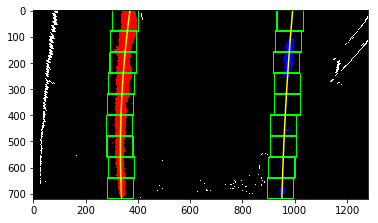

In [13]:
binary_warped = np.copy(warped_imgs[0])
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangle_data = sliding_window_polyfit(binary_warped)

out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

nonzero = binary_warped.nonzero()
nonzerox = np.array(nonzero[1])
nonzeroy = np.array(nonzero[0])

x_left = nonzerox[left_lane_inds]
y_left = nonzeroy[left_lane_inds]
x_right = nonzerox[right_lane_inds]
y_right = nonzeroy[right_lane_inds]

out_img[y_left, x_left] = [255, 0 ,0]
out_img[y_right, x_right] = [0, 0, 255]

for rectangle in range(len(rectangle_data)):
    cv2.rectangle(out_img, (rectangle_data[rectangle][2], rectangle_data[rectangle][0]), (rectangle_data[rectangle][3], rectangle_data[rectangle][1]), (0, 255, 0), 3)
    cv2.rectangle(out_img, (rectangle_data[rectangle][4], rectangle_data[rectangle][0]), (rectangle_data[rectangle][5], rectangle_data[rectangle][1]), (0, 255, 0), 3)

y = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
left_fitx = left_fit[0] * y**2 + left_fit[1] * y + left_fit[2]
right_fitx = right_fit[0] * y**2 + right_fit[1] * y + right_fit[2]

plt.plot(left_fitx, y, color='yellow')
plt.plot(right_fitx, y, color='yellow')


plt.imshow(out_img, cmap = 'gray')

In [14]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped_2")
# It's now much easier to find line pixels!
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit_new = np.polyfit(lefty, leftx, 2)
    right_fit_new = np.polyfit(righty, rightx, 2)
    
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

print('...')

...


(720, 0)

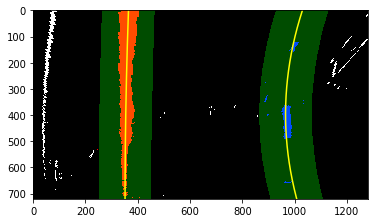

In [15]:
binary_warped_new = np.copy(warped_imgs[3])

left_fit_new, right_fit_new, left_lane_inds_new, right_lane_inds_new = polyfit_using_prev_fit(binary_warped_new, left_fit, right_fit)

ploty_new = np.linspace(0, binary_warped_new.shape[0] - 1, binary_warped_new.shape[0])
left_fitx_new = left_fit_new[0] * ploty_new**2 + left_fit_new[1] * ploty_new + left_fit_new[2]
right_fitx_new = right_fit_new[0] * ploty_new**2 + right_fit_new[1] * ploty_new + right_fit_new[2]

out_img_new = np.dstack((binary_warped_new, binary_warped_new, binary_warped_new)) * 255
nonzero_new = binary_warped_new.nonzero()
nonzeroy_new = np.array(nonzero_new[0])
nonzerox_new = np.array(nonzero_new[1])

out_img_new[nonzeroy_new[left_lane_inds_new], nonzerox_new[left_lane_inds_new]] = [255, 0, 0]
out_img_new[nonzeroy_new[right_lane_inds_new], nonzerox_new[right_lane_inds_new]] = [0, 0, 255]

window_img = np.zeros_like(out_img_new)
margin = 100
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx_new-margin, ploty_new]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx_new+margin, 
                              ploty_new])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx_new-margin, ploty_new]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx_new+margin, 
                              ploty_new])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img_new, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx_new, ploty_new, color='yellow')
plt.plot(right_fitx_new, ploty_new, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [16]:
# Curvature calculating function inspired by the lectures and by jeremy shannon

def curv(bin_img, left_fit, right_fit, l_lane_inds, r_lane_inds):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, bin_img.shape[0] - 1, bin_img.shape[0])
    y_eval = np.max(ploty)
    
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    lane_mid = (np.mean(leftx) + np.mean(rightx))/2
    center = abs(bin_img.shape[1]/2 - lane_mid) * xm_per_pix
    
    return left_curverad, right_curverad, center

In [17]:
rad_l, rad_r, d_center = curv(binary_warped_new, left_fit_new, right_fit_new, left_lane_inds_new, right_lane_inds_new)
print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

Radius of curvature for example: 6618.40799038 m, 403.217755389 m
Distance from lane center for example: 0.125768736738 m


In [18]:
# Lane ssuperimposing function inspired by the lectures and by jeremy shannon

def draw_lane(original_img, bin_img, l_fit, r_fit, Minv):

    new_img = np.copy(original_img)
    # if l_fit is None or r_fit is None:
    #     return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(bin_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    

    ploty = np.linspace(0, bin_img.shape[0] - 1, bin_img.shape[0])# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (bin_img.shape[1], bin_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.3, 0)
    return result


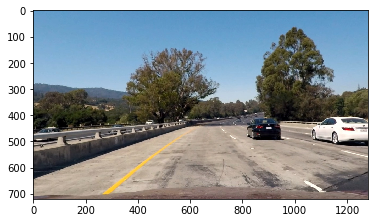

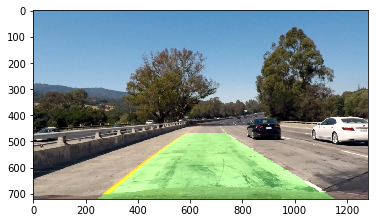

In [19]:
orginal = np.copy(test_imgs[0])
orginal = undistort(orginal, ret, mtx, dist)
plt.imshow(orginal)
plt.figure()
exampleImg_out1 = draw_lane(orginal, piped, left_fit, right_fit, Minv)
plt.imshow(exampleImg_out1)


In [20]:
# Function from Jeremy Shannon, I am not really familiar with super imposing text, and as i am WAY over deadline
# I borrowed this function

def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    text = '{:04.3f}'.format(center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img
print('...')

...


...


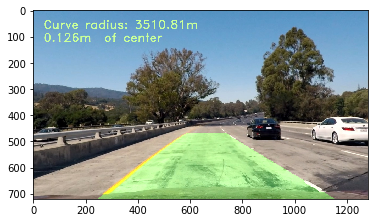

In [21]:
exampleImg_out2 = draw_data(exampleImg_out1, (rad_l+rad_r)/2, d_center)
plt.imshow(exampleImg_out2)
print('...')

In [22]:
# Functions of the Line class are also credited to Jeremy shannon. I did not udnerstand well from the lecturees to be honest,
# But i was able to use it.

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


            

print('...')

...


In [23]:
# For a long time i could not implement the final processing function as i did 
# not know how to glue it all together, but after reading several other submissions, i understood more and was able to
# implement it, and deal with exceptions and undetected lanes through averaging. Skeleton inspired also by jeremy shannon
def process(img):
    
    copy = np.copy(img)
    img_bin, Minv = pipeline(copy)

    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
        
        prev_fit.append([l_fit, r_fit])
        prev_inds.append([l_lane_inds, r_lane_inds])


        l_fit_arr.append(prev_fit[-1][0])
        r_fit_arr.append(prev_fit[-1][1])

        l_fit = np.mean(np.asarray(l_fit_arr)[-3:], axis = 0)
        r_fit = np.mean(np.asarray(r_fit_arr)[-3:], axis = 0)
        
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
        prev_fit.append([l_fit, r_fit])
        prev_inds.append([l_lane_inds, r_lane_inds])
        
        l_fit_arr.append(prev_fit[-1][0])
        r_fit_arr.append(prev_fit[-1][1])

        l_fit = np.mean(np.asarray(l_fit_arr)[-3:], axis = 0)
        r_fit = np.mean(np.asarray(r_fit_arr)[-3:], axis = 0)

            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    undistorted = undistort(copy, ret, mtx, dist)
    img_out1 = draw_lane(undistorted, img_bin, l_line.best_fit, r_line.best_fit, Minv)
    rad_l, rad_r, d_center = curv(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
    img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)

    
    return img_out

In [24]:
l_line = Line()
r_line = Line()
prev_fit = []
prev_inds = []
l_fit_arr = []
r_fit_arr = []

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(0,10)

processed_video = video_input1.fl_image(process)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [07:14<00:00,  3.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 7min 16s
